In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/ChangeDetectionUSADividedSplit-png.zip' -d '/content/ChangeDetectionUSADividedSplit-png'

Streaming output truncated to the last 5000 lines.
  inflating: /content/ChangeDetectionUSADividedSplit-png/val/Masks/T2019/m_Louisianna_LakeCharles_NE_2019_2.png  
  inflating: /content/ChangeDetectionUSADividedSplit-png/val/Masks/T2019/m_Louisianna_LakeCharles_NE_2019_3.png  
  inflating: /content/ChangeDetectionUSADividedSplit-png/val/Masks/T2019/m_Louisianna_NewOrleans_NE_2019_1.png  
  inflating: /content/ChangeDetectionUSADividedSplit-png/val/Masks/T2019/m_Louisianna_NewOrleans_NE_2019_2.png  
  inflating: /content/ChangeDetectionUSADividedSplit-png/val/Masks/T2019/m_Louisianna_NewOrleans_NE_2019_3.png  
  inflating: /content/ChangeDetectionUSADividedSplit-png/val/Masks/T2019/m_Louisianna_NewOrleans_NE_2019_4.png  
  inflating: /content/ChangeDetectionUSADividedSplit-png/val/Masks/T2019/m_Louisianna_Shreveport_C_2019_1.png  
  inflating: /content/ChangeDetectionUSADividedSplit-png/val/Masks/T2019/m_Louisianna_Shreveport_C_2019_2.png  
  inflating: /content/ChangeDetectionUSADivid

# Data Preparation

In [3]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

# DataLoader for Change Detection
class ChangeDetectionDataset(Dataset):
    def __init__(self, t2019_dir, t2024_dir, mask_dir, classes, transform=None):
        self.t2019_dir = t2019_dir
        self.t2024_dir = t2024_dir
        self.mask_dir = mask_dir
        self.classes = classes
        self.transform = transform
        self.t2019_paths = sorted([f for f in os.listdir(t2019_dir) if f.endswith('.png')])
        self.t2024_paths = sorted([f for f in os.listdir(t2024_dir) if f.endswith('.png')])
        self.mask_paths = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.t2019_paths)

    def __getitem__(self, index):
        # Load 2019 and 2024 images
        img_t2019 = np.array(Image.open(os.path.join(self.t2019_dir, self.t2019_paths[index])),
                            dtype=np.float32) / 255.0
        img_t2024 = np.array(Image.open(os.path.join(self.t2024_dir, self.t2024_paths[index])),
                            dtype=np.float32) / 255.0

        # Load mask and normalize values
        mask = np.array(Image.open(os.path.join(self.mask_dir, self.mask_paths[index])), dtype=np.int64)

        # Normalize mask values
        mask[mask == 127] = 1
        mask[mask == 255] = 2

        # Convert to PyTorch tensors
        img_t2019 = torch.from_numpy(img_t2019).permute(2, 0, 1)
        img_t2024 = torch.from_numpy(img_t2024).permute(2, 0, 1)
        mask = torch.from_numpy(mask)

        return img_t2019, img_t2024, mask

# Define class labels
CLASSES = ['no_change', 'increase_vegetation', 'decrease_vegetation']
ROOT_DIRECTORY = "ChangeDetectionUSADividedSplit-png"
CHANGE_MASK = "cd1_Output"

# DataLoader Setup
train_dataset = ChangeDetectionDataset(
    t2019_dir=f"{ROOT_DIRECTORY}/train/Images/T2019",
    t2024_dir=f"{ROOT_DIRECTORY}/train/Images/T2024",
    mask_dir=f"{ROOT_DIRECTORY}/train/{CHANGE_MASK}",
    classes=CLASSES
)

val_dataset = ChangeDetectionDataset(
    t2019_dir=f"{ROOT_DIRECTORY}/val/Images/T2019",
    t2024_dir=f"{ROOT_DIRECTORY}/val/Images/T2024",
    mask_dir=f"{ROOT_DIRECTORY}/val/{CHANGE_MASK}",
    classes=CLASSES
)

test_dataset = ChangeDetectionDataset(
    t2019_dir=f"{ROOT_DIRECTORY}/test/Images/T2019",
    t2024_dir=f"{ROOT_DIRECTORY}/test/Images/T2024",
    mask_dir=f"{ROOT_DIRECTORY}/test/{CHANGE_MASK}",
    classes=CLASSES
)

# Create DataLoader instances
num_workers = 8
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

def describe_loader(loader_type):
    print("Batch size: ", loader_type.batch_size)
    print("Shape: ", loader_type.dataset[0][0].shape,
          loader_type.dataset[0][1].shape, loader_type.dataset[0][2].shape)
    print("Number of images: ", len(loader_type.dataset))
    print("Classes: ", loader_type.dataset.classes)

print("------------Train------------")
describe_loader(train_loader)
print("------------Val------------")
describe_loader(val_loader)
print("------------Test------------")
describe_loader(test_loader)

------------Train------------
Batch size:  32
Shape:  torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([256, 256])
Number of images:  2714
Classes:  ['no_change', 'increase_vegetation', 'decrease_vegetation']
------------Val------------
Batch size:  32
Shape:  torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([256, 256])
Number of images:  582
Classes:  ['no_change', 'increase_vegetation', 'decrease_vegetation']
------------Test------------
Batch size:  32
Shape:  torch.Size([3, 256, 256]) torch.Size([3, 256, 256]) torch.Size([256, 256])
Number of images:  582
Classes:  ['no_change', 'increase_vegetation', 'decrease_vegetation']


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Data Visualization

[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]
[0 1 2]


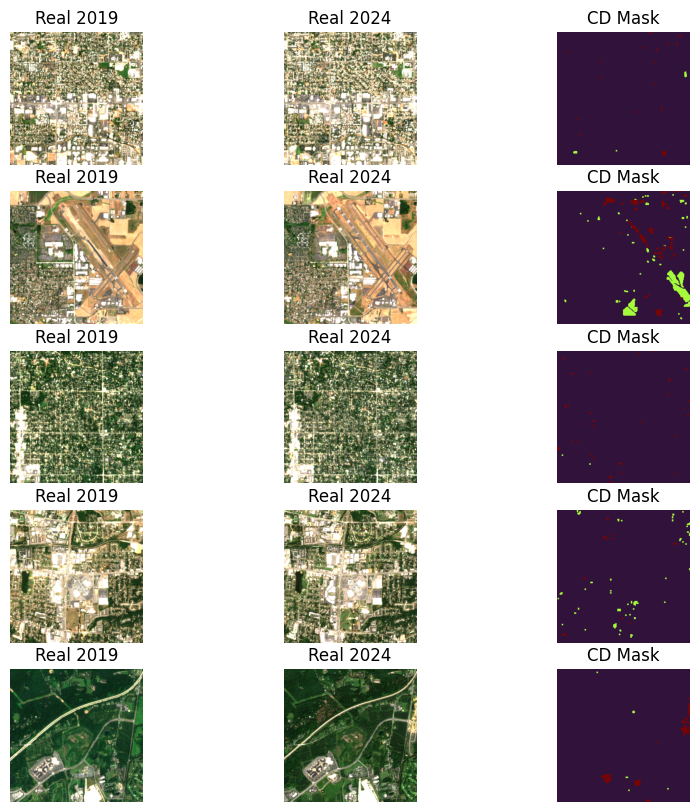

In [4]:
import matplotlib.pyplot as plt
import random

# Set up the plot size and remove axes
fig, axs = plt.subplots(5, 3, figsize=(10,10))
#plt.figure(figsize=(10, 10))  # Set the figure size to be larger

for i in range(5):
    j = random.randint(0, len(train_dataset) - 1)
#for i in range(len()):
    image1, image2, mask = train_dataset[j]

    # Display images
    axs[i, 0].imshow(image1.permute(1, 2, 0))
    axs[i, 0].set_title(f"Real 2019")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(image2.permute(1, 2, 0))
    axs[i, 1].set_title(f"Real 2024")
    axs[i, 1].axis("off")

    axs[i, 2].imshow(mask, cmap="turbo")
    print(np.unique(mask))
    axs[i, 2].set_title(f"CD Mask")
    axs[i, 2].axis("off")

plt.show()

## Siamese U-Net

### Model Definition and Training Loop

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.padding import ReplicationPad2d
import torch.optim as optim

class SiamUnet_conc(nn.Module):
    """SiamUnet_conc segmentation network for multiclass change detection."""

    def __init__(self, input_nbr, label_nbr):
        super(SiamUnet_conc, self).__init__()

        self.input_nbr = input_nbr

        # Encoder Layers
        self.conv11 = nn.Conv2d(input_nbr, 16, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(16)
        self.do11 = nn.Dropout2d(p=0.2)
        self.conv12 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(16)
        self.do12 = nn.Dropout2d(p=0.2)

        self.conv21 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(32)
        self.do21 = nn.Dropout2d(p=0.2)
        self.conv22 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(32)
        self.do22 = nn.Dropout2d(p=0.2)

        self.conv31 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(64)
        self.do31 = nn.Dropout2d(p=0.2)
        self.conv32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(64)
        self.do32 = nn.Dropout2d(p=0.2)
        self.conv33 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(64)
        self.do33 = nn.Dropout2d(p=0.2)

        self.conv41 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(128)
        self.do41 = nn.Dropout2d(p=0.2)
        self.conv42 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(128)
        self.do42 = nn.Dropout2d(p=0.2)
        self.conv43 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(128)
        self.do43 = nn.Dropout2d(p=0.2)

        self.upconv4 = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1, stride=2, output_padding=1)

        # Decoder Layers
        self.conv43d = nn.ConvTranspose2d(384, 128, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(128)
        self.do43d = nn.Dropout2d(p=0.2)
        self.conv42d = nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(128)
        self.do42d = nn.Dropout2d(p=0.2)
        self.conv41d = nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(64)
        self.do41d = nn.Dropout2d(p=0.2)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv33d = nn.ConvTranspose2d(192, 64, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(64)
        self.do33d = nn.Dropout2d(p=0.2)
        self.conv32d = nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(64)
        self.do32d = nn.Dropout2d(p=0.2)
        self.conv31d = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(32)
        self.do31d = nn.Dropout2d(p=0.2)

        self.upconv2 = nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv22d = nn.ConvTranspose2d(96, 32, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(32)
        self.do22d = nn.Dropout2d(p=0.2)
        self.conv21d = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(16)
        self.do21d = nn.Dropout2d(p=0.2)

        self.upconv1 = nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1, stride=2, output_padding=1)

        self.conv12d = nn.ConvTranspose2d(48, 16, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(16)
        self.do12d = nn.Dropout2d(p=0.2)
        # self.conv11d = nn.ConvTranspose2d(16, label_nbr, kernel_size=3, padding=1)
        self.conv11d = nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1)

        # Multiclass activation (Softmax instead of LogSoftmax)
        self.sm = nn.Softmax(dim=1)

    def forward(self, x1, x2):

        """Forward method."""
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x1))))
        x12_1 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_1, kernel_size=2, stride=2)


        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_1 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_1, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_1 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_1, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_1 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_1, kernel_size=2, stride=2)


        ####################################################
        # Stage 1
        x11 = self.do11(F.relu(self.bn11(self.conv11(x2))))
        x12_2 = self.do12(F.relu(self.bn12(self.conv12(x11))))
        x1p = F.max_pool2d(x12_2, kernel_size=2, stride=2)

        # Stage 2
        x21 = self.do21(F.relu(self.bn21(self.conv21(x1p))))
        x22_2 = self.do22(F.relu(self.bn22(self.conv22(x21))))
        x2p = F.max_pool2d(x22_2, kernel_size=2, stride=2)

        # Stage 3
        x31 = self.do31(F.relu(self.bn31(self.conv31(x2p))))
        x32 = self.do32(F.relu(self.bn32(self.conv32(x31))))
        x33_2 = self.do33(F.relu(self.bn33(self.conv33(x32))))
        x3p = F.max_pool2d(x33_2, kernel_size=2, stride=2)

        # Stage 4
        x41 = self.do41(F.relu(self.bn41(self.conv41(x3p))))
        x42 = self.do42(F.relu(self.bn42(self.conv42(x41))))
        x43_2 = self.do43(F.relu(self.bn43(self.conv43(x42))))
        x4p = F.max_pool2d(x43_2, kernel_size=2, stride=2)


        ####################################################
        # Stage 4d
        x4d = self.upconv4(x4p)
        pad4 = ReplicationPad2d((0, x43_1.size(3) - x4d.size(3), 0, x43_1.size(2) - x4d.size(2)))
        x4d = torch.cat((pad4(x4d), x43_1, x43_2), 1)
        x43d = self.do43d(F.relu(self.bn43d(self.conv43d(x4d))))
        x42d = self.do42d(F.relu(self.bn42d(self.conv42d(x43d))))
        x41d = self.do41d(F.relu(self.bn41d(self.conv41d(x42d))))

        # Stage 3d
        x3d = self.upconv3(x41d)
        pad3 = ReplicationPad2d((0, x33_1.size(3) - x3d.size(3), 0, x33_1.size(2) - x3d.size(2)))
        x3d = torch.cat((pad3(x3d), x33_1, x33_2), 1)
        x33d = self.do33d(F.relu(self.bn33d(self.conv33d(x3d))))
        x32d = self.do32d(F.relu(self.bn32d(self.conv32d(x33d))))
        x31d = self.do31d(F.relu(self.bn31d(self.conv31d(x32d))))

        # Stage 2d
        x2d = self.upconv2(x31d)
        pad2 = ReplicationPad2d((0, x22_1.size(3) - x2d.size(3), 0, x22_1.size(2) - x2d.size(2)))
        x2d = torch.cat((pad2(x2d), x22_1, x22_2), 1)
        x22d = self.do22d(F.relu(self.bn22d(self.conv22d(x2d))))
        x21d = self.do21d(F.relu(self.bn21d(self.conv21d(x22d))))

        # Stage 1d
        x1d = self.upconv1(x21d)
        pad1 = ReplicationPad2d((0, x12_1.size(3) - x1d.size(3), 0, x12_1.size(2) - x1d.size(2)))
        x1d = torch.cat((pad1(x1d), x12_1, x12_2), 1)
        x12d = self.do12d(F.relu(self.bn12d(self.conv12d(x1d))))
        x11d = self.conv11d(x12d)

        return self.sm(x11d)

def calculate_metrics(outputs, labels):
    # Implementation of calculate_metrics function (needed for training)
    preds = torch.argmax(outputs, dim=1)

    # Calculate accuracy
    acc = (preds == labels).float().mean().item()

    # Calculate metrics for each class and average them
    metrics = []
    for class_idx in range(outputs.size(1)):
        true_positives = ((preds == class_idx) & (labels == class_idx)).sum().float()
        false_positives = ((preds == class_idx) & (labels != class_idx)).sum().float()
        false_negatives = ((preds != class_idx) & (labels == class_idx)).sum().float()

        # Precision
        precision = true_positives / (true_positives + false_positives + 1e-8)

        # Recall
        recall = true_positives / (true_positives + false_negatives + 1e-8)

        # Dice coefficient
        dice = 2 * true_positives / (2 * true_positives + false_positives + false_negatives + 1e-8)

        # IoU (Intersection over Union)
        iou = true_positives / (true_positives + false_positives + false_negatives + 1e-8)

        metrics.append([precision.item(), recall.item(), dice.item(), iou.item()])

    # Average metrics across classes
    avg_metrics = torch.tensor(metrics).mean(dim=0)
    return acc, avg_metrics[0], avg_metrics[1], avg_metrics[2], avg_metrics[3]


def calculate_effective_weights(train_loader, device, num_classes=3, method='balanced'):
    """Calculate class weights with different strategies to handle class imbalance

    Args:
        train_loader: DataLoader containing training data
        device: torch device
        num_classes: number of classes (default: 3)
        method: weighting strategy ('balanced', 'square_balanced', or 'custom')
    """
    class_counts = torch.zeros(num_classes)
    total_pixels = 0

    # Count class frequencies
    for _, _, labels in train_loader:
        labels = labels.to(device)
        for i in range(num_classes):
            class_counts[i] += (labels == i).sum().item()
        total_pixels += labels.numel()

    class_frequencies = class_counts / total_pixels

    if method == 'balanced':
        # Standard balanced weighting (inverse frequency)
        weights = 1.0 / class_frequencies

    elif method == 'square_balanced':
        # Square root of inverse frequencies (less aggressive balancing)
        weights = torch.sqrt(1.0 / class_frequencies)

    elif method == 'custom':
        # Custom weighting that maintains some natural class distribution
        # Adjust these factors based on your domain knowledge
        base_weights = 1.0 / class_frequencies
        adjustment_factors = torch.tensor([0.7, 1.2, 1.2])  # Reduce weight of class 0, increase others
        weights = base_weights * adjustment_factors

    # Normalize weights to sum to num_classes
    weights = weights * (num_classes / weights.sum())

    return weights, class_frequencies


def train_model_balanced(model, train_loader, val_loader, num_epochs=50, device='cuda',
                         weighting_method='square_balanced', LOSS='focal', checkpoint_path='best_model_multiclass.pt'):
    """
    Training function with checkpoint loading and saving capability.
    Args:
        model: The model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Total number of epochs to train
        device: Device to train on
        weighting_method: Method for calculating class weights
        LOSS: Loss function to use ('focal' or 'CE')
        checkpoint_path: Path to save/load checkpoint
    """
    start_epoch = 0
    best_val_iou = 0

    # Try to load checkpoint if it exists
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        try:
            checkpoint = torch.load(checkpoint_path, weights_only=True)
            model.load_state_dict(checkpoint['model_state_dict'])
            start_epoch = checkpoint['epoch']
            best_val_iou = checkpoint['best_val_iou']
            print(f"Resuming from epoch {start_epoch} with best IoU: {best_val_iou:.4f}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting training from scratch")
            start_epoch = 0
            best_val_iou = 0
    else:
        print("No checkpoint found. Starting training from scratch")

    # Calculate class weights
    class_weights,_ = calculate_effective_weights(train_loader, device, num_classes=3, method=weighting_method)
    print(f"Class weights: {class_weights}")

    # Define Focal Loss
    class FocalLoss(nn.Module):
        def __init__(self, weight=None, gamma=2.0):
            super().__init__()
            self.weight = weight
            self.gamma = gamma

        def forward(self, input, target):
            ce_loss = F.cross_entropy(input, target, reduction='none', weight=self.weight)
            pt = torch.exp(-ce_loss)
            focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
            return focal_loss

    # Select loss function
    if LOSS.lower() == 'focal':
        focal_gamma = 2.0
        criterion = FocalLoss(weight=class_weights.to(device), gamma=focal_gamma)
    else:  # 'CE'
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # Initialize optimizer and scheduler
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                    factor=0.5, patience=5,
                                                    verbose=True)

    # Load optimizer and scheduler states if available
    if os.path.exists(checkpoint_path):
        try:
            checkpoint = torch.load(checkpoint_path, weights_only=True)
            if 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            if 'scheduler_state_dict' in checkpoint:
                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        except Exception as e:
            print(f"Error loading optimizer/scheduler states: {e}")

    model.to(device)

    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        train_acc_sum = 0
        train_precision_sum = 0
        train_recall_sum = 0
        train_dice_sum = 0
        train_iou_sum = 0
        train_samples = 0
        train_class_predictions = torch.zeros(3).to(device)

        for inputs1, inputs2, labels in train_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)

            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Calculate metrics for training
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            batch_size = inputs1.size(0)

            running_train_loss += loss.item() * batch_size
            train_acc_sum += acc * batch_size
            train_precision_sum += precision * batch_size
            train_recall_sum += recall * batch_size
            train_dice_sum += dice * batch_size
            train_iou_sum += iou * batch_size
            train_samples += batch_size

            # Track class distribution
            preds = torch.argmax(outputs, dim=1)
            for i in range(3):
                train_class_predictions[i] += (preds == i).sum().item()

        # Calculate training metrics
        train_loss = running_train_loss / train_samples
        train_acc = train_acc_sum / train_samples
        train_precision = train_precision_sum / train_samples
        train_recall = train_recall_sum / train_samples
        train_dice = train_dice_sum / train_samples
        train_iou = train_iou_sum / train_samples
        train_class_dist = train_class_predictions / train_class_predictions.sum()

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_acc_sum = 0
        val_precision_sum = 0
        val_recall_sum = 0
        val_dice_sum = 0
        val_iou_sum = 0
        val_samples = 0
        val_class_predictions = torch.zeros(3).to(device)

        with torch.no_grad():
            for inputs1, inputs2, labels in val_loader:
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)
                loss = criterion(outputs, labels)

                # Calculate validation metrics
                acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
                batch_size = inputs1.size(0)

                running_val_loss += loss.item() * batch_size
                val_acc_sum += acc * batch_size
                val_precision_sum += precision * batch_size
                val_recall_sum += recall * batch_size
                val_dice_sum += dice * batch_size
                val_iou_sum += iou * batch_size
                val_samples += batch_size

                # Track class distribution
                preds = torch.argmax(outputs, dim=1)
                for i in range(3):
                    val_class_predictions[i] += (preds == i).sum().item()

        # Calculate validation metrics
        val_loss = running_val_loss / val_samples
        val_acc = val_acc_sum / val_samples
        val_precision = val_precision_sum / val_samples
        val_recall = val_recall_sum / val_samples
        val_dice = val_dice_sum / val_samples
        val_iou = val_iou_sum / val_samples
        val_class_dist = val_class_predictions / val_class_predictions.sum()

        # Update learning rate
        scheduler.step(val_iou)

        # Print metrics
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print('\nTraining Metrics:')
        print(f'Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | IoU: {train_iou:.4f}')
        print(f'Precision: {train_precision:.4f} | Recall: {train_recall:.4f} | Dice: {train_dice:.4f}')
        print(f'Class distribution: {train_class_dist.cpu().numpy()}')

        print('\nValidation Metrics:')
        print(f'Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | IoU: {val_iou:.4f}')
        print(f'Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | Dice: {val_dice:.4f}')
        print(f'Class distribution: {val_class_dist.cpu().numpy()}')

        # Save checkpoint if it's the best model
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_iou': best_val_iou,
                'train_loss': train_loss,
                'val_loss': val_loss
            }
            torch.save(checkpoint, checkpoint_path)
            print(f'\nSaved new best model with validation IoU: {val_iou:.4f}')

    return model

# Initialize and train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiamUnet_conc(input_nbr = 3, label_nbr=3).to(device)
train_model_balanced(model, train_loader, val_loader,
                     num_epochs=50, device=device,
                     weighting_method='square_balanced',LOSS='CE')


No checkpoint found. Starting training from scratch
Class weights: tensor([0.1707, 1.6536, 1.1757])

Epoch 1/50:

Training Metrics:
Loss: 0.9728 | Acc: 0.6518 | IoU: 0.2380
Precision: 0.3489 | Recall: 0.4477 | Dice: 0.3024
Class distribution: [0.65483344 0.05820715 0.2869594 ]

Validation Metrics:
Loss: 0.9153 | Acc: 0.7496 | IoU: 0.3125
Precision: 0.3993 | Recall: 0.6713 | Dice: 0.3965
Class distribution: [0.7381997  0.04119097 0.22060934]

Saved new best model with validation IoU: 0.3125

Epoch 2/50:

Training Metrics:
Loss: 0.8503 | Acc: 0.8376 | IoU: 0.3292
Precision: 0.3853 | Recall: 0.5495 | Dice: 0.3959
Class distribution: [0.8399576  0.03859225 0.1214501 ]

Validation Metrics:
Loss: 0.7865 | Acc: 0.9051 | IoU: 0.4575
Precision: 0.5549 | Recall: 0.7051 | Dice: 0.5606
Class distribution: [0.89444864 0.01017627 0.09537514]

Saved new best model with validation IoU: 0.4575

Epoch 3/50:

Training Metrics:
Loss: 0.7701 | Acc: 0.9181 | IoU: 0.4093
Precision: 0.4666 | Recall: 0.6092 | 

SiamUnet_conc(
  (conv11): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do11): Dropout2d(p=0.2, inplace=False)
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do12): Dropout2d(p=0.2, inplace=False)
  (conv21): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn21): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do21): Dropout2d(p=0.2, inplace=False)
  (conv22): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (do22): Dropout2d(p=0.2, inplace=False)
  (conv31): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn31): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

# Eval and Result Plotting

Running detailed model output analysis...

Model Output Analysis:
--------------------------------------------------

Sample 1:
Raw output range: 0.0000 to 1.0000
Class probabilities: [0.57102144 0.21267179 0.21630679]
Unique predicted classes: [0 1 2]
Unique true classes: [0 1 2]

Sample 2:
Raw output range: 0.0000 to 1.0000
Class probabilities: [0.5707786  0.21436818 0.21485323]
Unique predicted classes: [0 1 2]
Unique true classes: [0 1 2]

Sample 3:
Raw output range: 0.0000 to 1.0000
Class probabilities: [0.56799173 0.21459833 0.21740997]
Unique predicted classes: [0 1 2]
Unique true classes: [0 1 2]

Sample 4:
Raw output range: 0.0000 to 1.0000
Class probabilities: [0.57066345 0.21324691 0.21608967]
Unique predicted classes: [0 1 2]
Unique true classes: [0 1 2]

Sample 5:
Raw output range: 0.0000 to 1.0000
Class probabilities: [0.5702704  0.21279782 0.21693178]
Unique predicted classes: [0 1 2]
Unique true classes: [0 1 2]


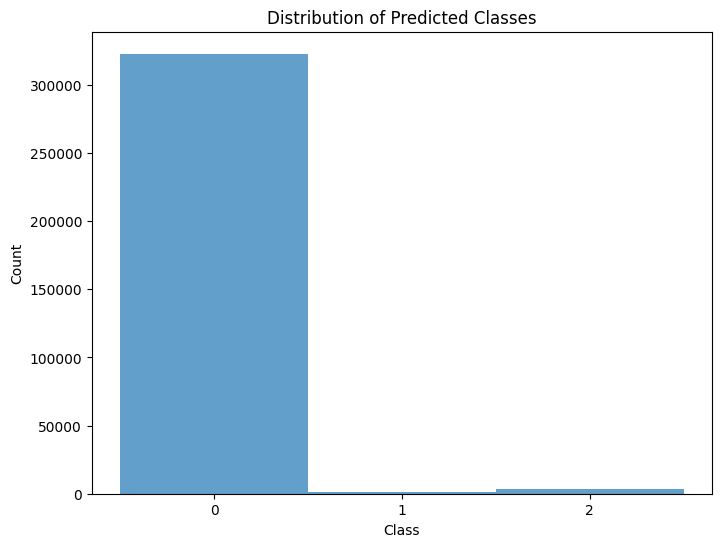


Running verbose testing with distribution analysis...

Prediction Analysis:
Unique predicted classes: [0 1 2]

Class distribution:
Class 0: 2032583 predictions (96.92%)
Class 1: 15654 predictions (0.75%)
Class 2: 48915 predictions (2.33%)

Softmax output analysis:
Class 0:
  Mean probability: 0.5641
  Max probability: 0.5761
Class 1:
  Mean probability: 0.2151
  Max probability: 0.5761
Class 2:
  Mean probability: 0.2208
  Max probability: 0.5761


In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import transforms
import torch.nn.functional as F

def analyze_model_outputs(model, test_loader, device, num_samples=5):
    model.eval()
    outputs_analysis = []

    with torch.no_grad():
        for inputs1, inputs2, labels in test_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            outputs = model(inputs1, inputs2)

            # Store raw outputs and probabilities
            for i in range(len(outputs)):
                raw_output = outputs[i].cpu()
                probabilities = F.softmax(raw_output, dim=0)
                predicted_class = torch.argmax(raw_output, dim=0)
                true_class = labels[i]

                outputs_analysis.append({
                    'raw_output': raw_output.numpy(),
                    'probabilities': probabilities.numpy(),
                    'predicted_class': predicted_class.numpy(),
                    'true_class': true_class.cpu().numpy()
                })

                if len(outputs_analysis) >= num_samples:
                    break
            if len(outputs_analysis) >= num_samples:
                break

    # Print analysis
    print("\nModel Output Analysis:")
    print("-" * 50)
    for i, analysis in enumerate(outputs_analysis):
        print(f"\nSample {i+1}:")
        print(f"Raw output range: {analysis['raw_output'].min():.4f} to {analysis['raw_output'].max():.4f}")
        print("Class probabilities:", analysis['probabilities'].mean(axis=(1,2)))
        print("Unique predicted classes:", np.unique(analysis['predicted_class']))
        print("Unique true classes:", np.unique(analysis['true_class']))

    # Plot distribution of predictions
    all_preds = np.concatenate([a['predicted_class'].flatten() for a in outputs_analysis])
    plt.figure(figsize=(8, 6))
    plt.hist(all_preds, bins=np.arange(-0.5, 3.5, 1), alpha=0.7)
    plt.title('Distribution of Predicted Classes')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1, 2])
    plt.show()

def test_model_verbose(model, test_loader, criterion, device):
    model.eval()
    class_predictions = []
    softmax_outputs = []

    with torch.no_grad():
        for inputs1, inputs2, labels in test_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            outputs = model(inputs1, inputs2)

            # Store predictions and softmax outputs
            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)

            class_predictions.extend(preds.cpu().numpy().flatten())
            softmax_outputs.extend(probs.cpu().numpy())

            if len(class_predictions) > 1000:  # Analyze first 1000 predictions
                break

    # Print analysis
    unique_classes = np.unique(class_predictions)
    print("\nPrediction Analysis:")
    print(f"Unique predicted classes: {unique_classes}")
    print("\nClass distribution:")
    for cls in range(3):
        count = np.sum(np.array(class_predictions) == cls)
        percentage = (count / len(class_predictions)) * 100
        print(f"Class {cls}: {count} predictions ({percentage:.2f}%)")

    # Analyze softmax outputs
    softmax_array = np.array(softmax_outputs)
    print("\nSoftmax output analysis:")
    for cls in range(3):
        mean_prob = np.mean(softmax_array[:, cls])
        max_prob = np.max(softmax_array[:, cls])
        print(f"Class {cls}:")
        print(f"  Mean probability: {mean_prob:.4f}")
        print(f"  Max probability: {max_prob:.4f}")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your trained model
    model = SiamUnet_conc(3, 3).to(device)

    # Load the checkpoint properly
    checkpoint = torch.load('best_model_multiclass.pt', weights_only=True)
    # Extract just the model state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Run analysis
    print("Running detailed model output analysis...")
    analyze_model_outputs(model, test_loader, device)

    print("\nRunning verbose testing with distribution analysis...")
    test_model_verbose(model, test_loader, nn.CrossEntropyLoss(), device)

if __name__ == '__main__':
    main()

Test Loss: 0.5796 | Test IoU: 0.6373 | Test Acc: 0.9718 | Test Precision: 0.6795 | Test Recall: 0.8773 | Test Dice: 0.7515


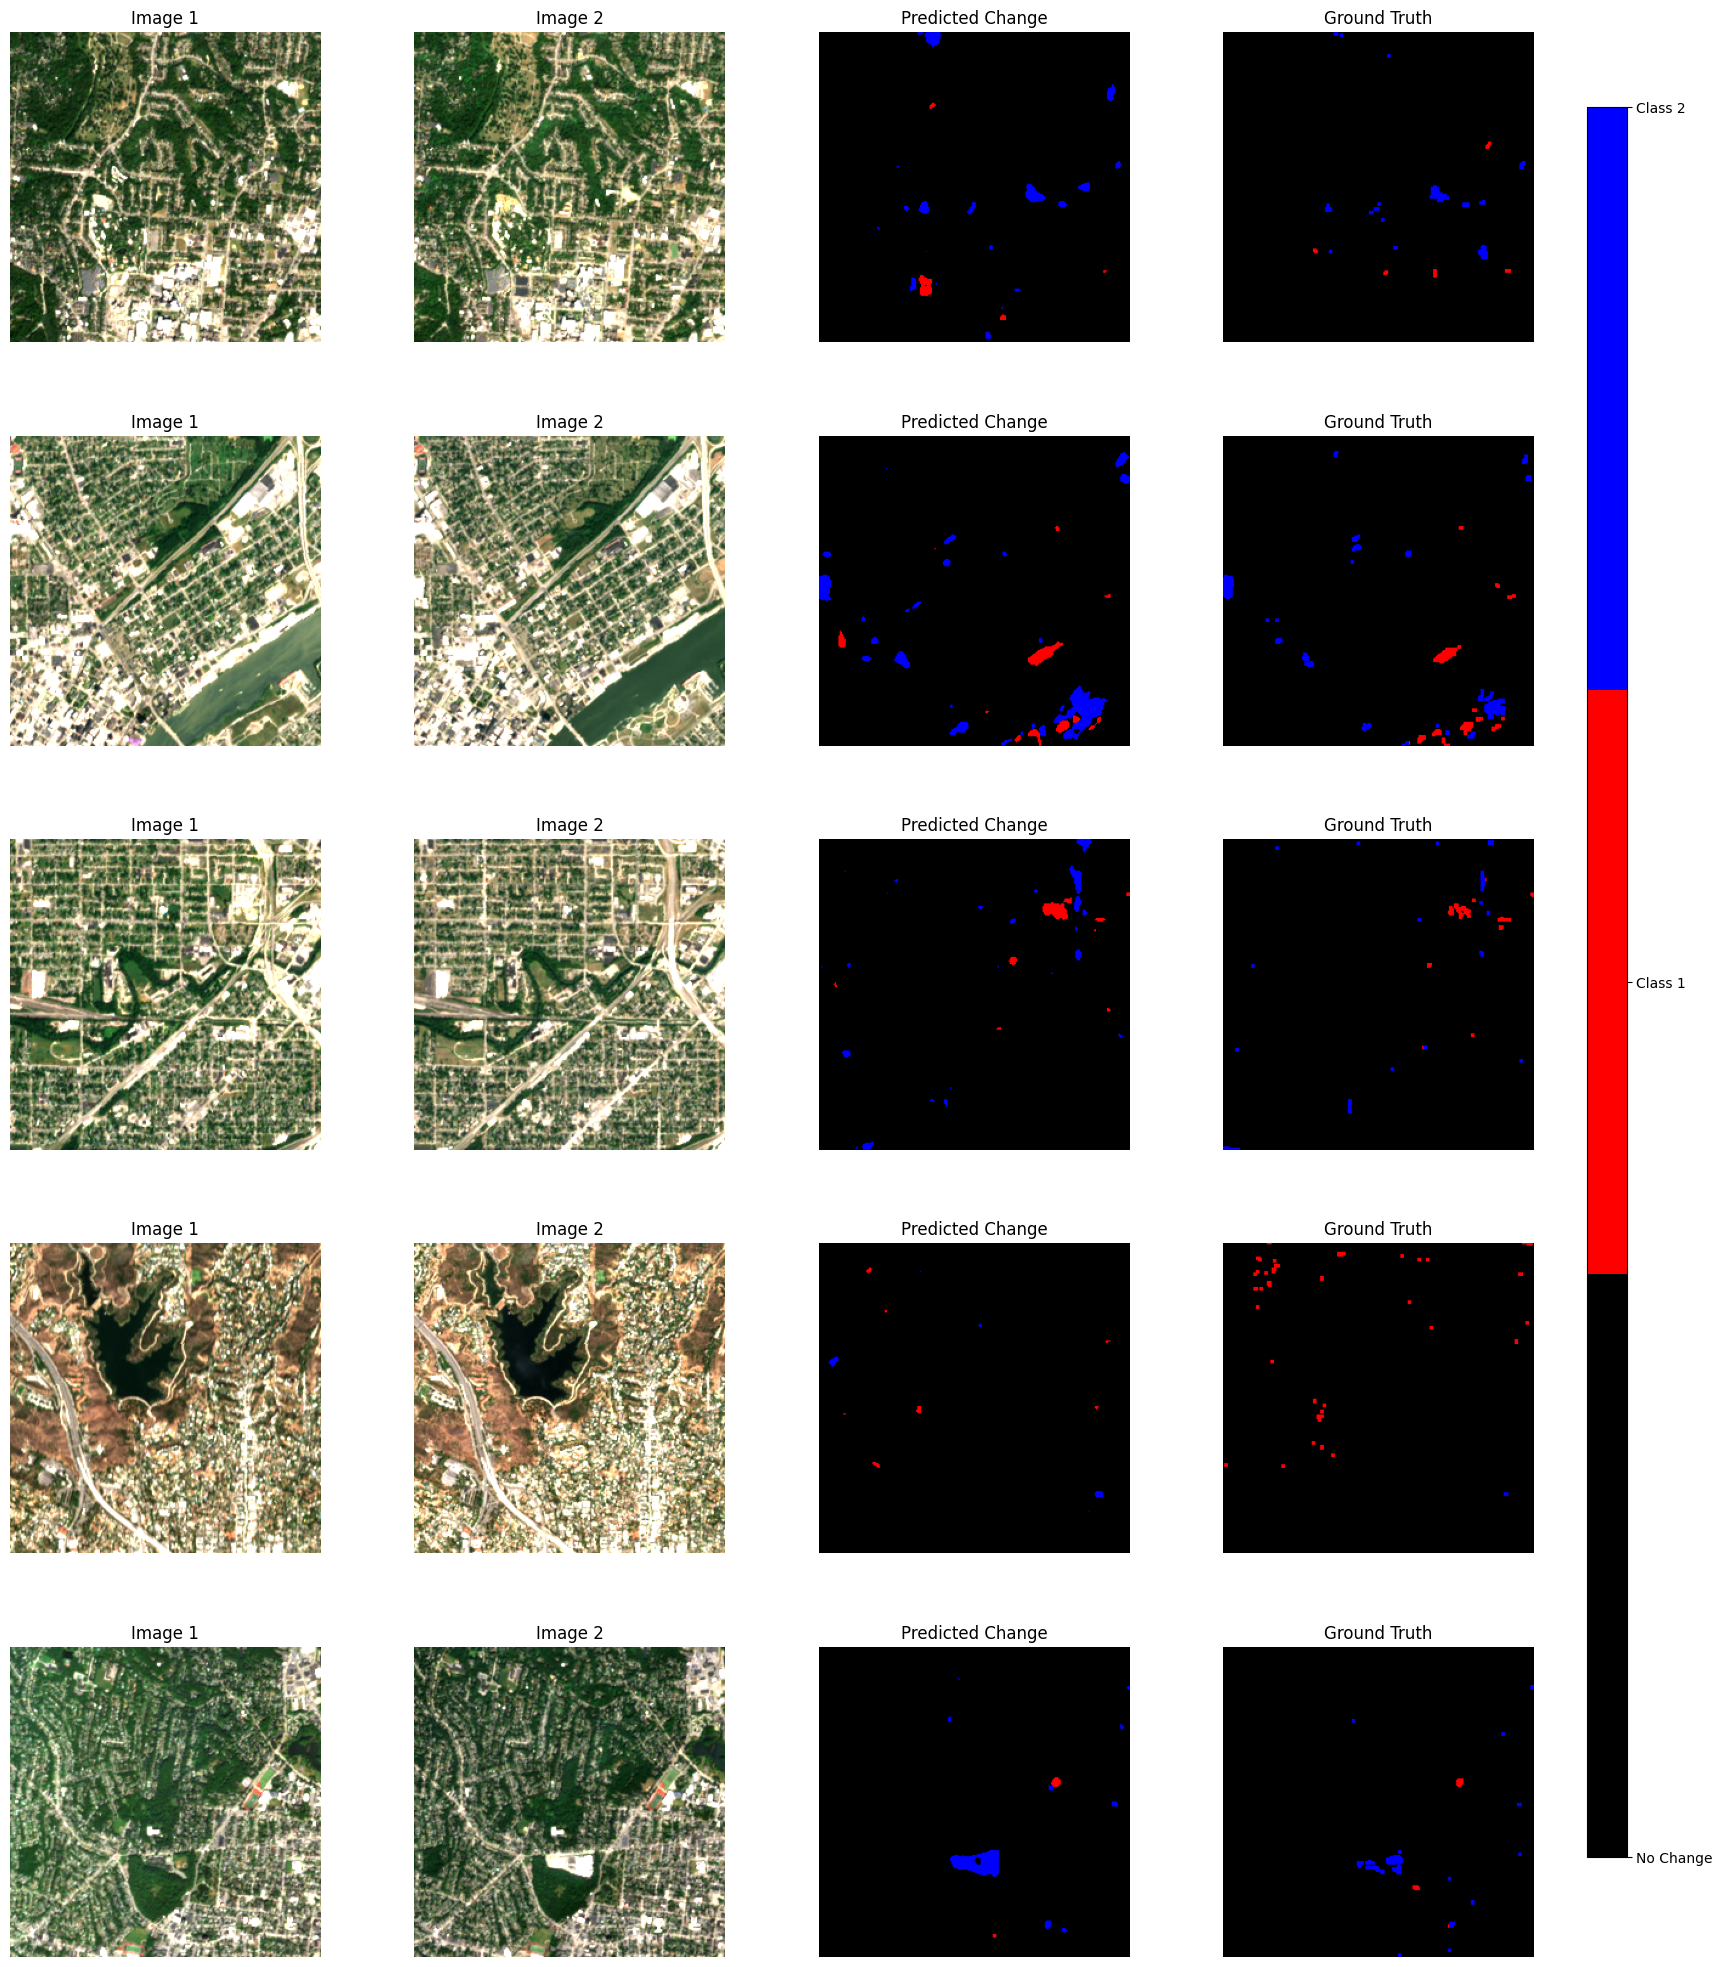

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import random

def test_model(model, test_loader, criterion, device):
    model.eval()
    running_test_loss = 0.0
    test_acc_sum = 0
    test_precision_sum = 0
    test_recall_sum = 0
    test_dice_sum = 0
    test_iou_sum = 0
    test_samples = 0

    # For visualization
    random_samples = []

    with torch.no_grad():
        for inputs1, inputs2, labels in test_loader:
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)

            # Calculate metrics
            # acc, precision, recall, dice, iou = calculate_metrics(outputs, labels, num_classes=3)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)

            # Accumulate metrics
            batch_size = inputs1.size(0)
            running_test_loss += loss.item() * batch_size
            test_acc_sum += acc * batch_size
            test_precision_sum += precision * batch_size
            test_recall_sum += recall * batch_size
            test_dice_sum += dice * batch_size
            test_iou_sum += iou * batch_size
            test_samples += batch_size

            # Store random samples for visualization
            if len(random_samples) < 5:
                # Get predictions
                preds = torch.argmax(outputs, dim=1)

                # Randomly select samples from this batch
                for i in range(min(batch_size, 5 - len(random_samples))):
                    if random.random() < 0.2:  # 20% chance to select each sample
                        random_samples.append({
                            'image1': inputs1[i].cpu(),
                            'image2': inputs2[i].cpu(),
                            'label': labels[i].cpu(),
                            'pred': preds[i].cpu(),
                            'probabilities': torch.softmax(outputs[i], dim=0).cpu()
                        })

    # Calculate final metrics
    test_loss = running_test_loss / test_samples
    test_acc = test_acc_sum / test_samples
    test_precision = test_precision_sum / test_samples
    test_recall = test_recall_sum / test_samples
    test_dice = test_dice_sum / test_samples
    test_iou = test_iou_sum / test_samples

    # Print metrics
    print(f'Test Loss: {test_loss:.4f} | '
          f'Test IoU: {test_iou:.4f} | '
          f'Test Acc: {test_acc:.4f} | '
          f'Test Precision: {test_precision:.4f} | '
          f'Test Recall: {test_recall:.4f} | '
          f'Test Dice: {test_dice:.4f}')

    return random_samples

def visualize_results(random_samples):
    # Create a figure with subplots
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    plt.subplots_adjust(hspace=0.3)

    # Define custom colormap for change masks
    colors = ['black', 'red', 'blue']  # Customize colors for your classes
    cmap = plt.matplotlib.colors.ListedColormap(colors)

    class_names = ['No Change', 'Class 1', 'Class 2']  # Replace with your class names

    for idx, sample in enumerate(random_samples):
        # Normalize and convert images for display
        img1 = sample['image1'].numpy().transpose(1, 2, 0)
        img2 = sample['image2'].numpy().transpose(1, 2, 0)
        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())

        # Get masks
        pred_mask = sample['pred'].numpy()
        true_mask = sample['label'].numpy()

        # Plot images and masks
        axes[idx, 0].imshow(img1)
        axes[idx, 0].set_title('Image 1')
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(img2)
        axes[idx, 1].set_title('Image 2')
        axes[idx, 1].axis('off')

        # Plot predicted mask
        pred_plot = axes[idx, 2].imshow(pred_mask, cmap=cmap, vmin=0, vmax=2)
        axes[idx, 2].set_title('Predicted Change')
        axes[idx, 2].axis('off')

        # Plot ground truth mask
        true_plot = axes[idx, 3].imshow(true_mask, cmap=cmap, vmin=0, vmax=2)
        axes[idx, 3].set_title('Ground Truth')
        axes[idx, 3].axis('off')

        # Add class probabilities as text
        probs = sample['probabilities'].mean(dim=(1, 2)).numpy()
        prob_text = "\n".join([f"{class_names[i]}: {probs[i]:.3f}" for i in range(3)])
        axes[idx, 2].text(1.5, 0.5, prob_text,
                         transform=axes[idx, 2].transAxes,
                         bbox=dict(facecolor='white', alpha=0.8))

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(pred_plot, cax=cbar_ax)
    cbar.set_ticks([0, 1, 2])
    cbar.set_ticklabels(class_names)

    plt.show()

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    model = SiamUnet_conc(3, 3).to(device)
    # Load the checkpoint properly
    checkpoint = torch.load('best_model_multiclass.pt', weights_only=True)
    # Extract just the model state dict
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Test the model
    criterion = nn.CrossEntropyLoss()
    random_samples = test_model(model, test_loader, criterion, device)

    # Visualize results
    visualize_results(random_samples)

if __name__ == '__main__':
    main()